In [3]:
# baseline model with dropout on the cifar10 dataset
import sys
from matplotlib import pyplot as plt
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD

import tensorflow as tf

import numpy as np
import math

import skimage
from skimage import io, data
from skimage.color import rgb2gray, rgba2rgb
import matplotlib.pyplot as plt
 




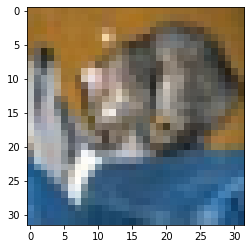

at testX: 0
done taking gradients for test
at trainX: 0
done taking gradients for train


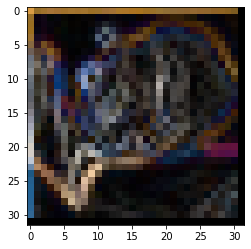

In [32]:
# load train and test dataset


# calculates channel-wise gradients of input images
# calculates 
def load_dataset():
	# load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # print(testX.shape)

    plt.imshow(testX[0,:,:,:])
    plt.show()

    # # for i in range(testX.shape[0]):
    # for i in range(3):
    #     if i%100==0:
    #         print("at testX:",i)

    #     full_image = testX[i,:,:,:]
    #     grad_image_c1 = calculate_grad_mag_image(full_image[:,:,0])    
    #     grad_image_c2 = calculate_grad_mag_image(full_image[:,:,1])
    #     grad_image_c3 = calculate_grad_mag_image(full_image[:,:,2])
    #     full_image[:,:,0] = grad_image_c1
    #     full_image[:,:,1] = grad_image_c2
    #     full_image[:,:,2] = grad_image_c3
    #     testX[i,:,:,:] = full_image

    # print("done taking gradients for test")

    # for i in range(3):
    #     if i%100==0:
    #         print("at trainX:",i)
    #     full_image = trainX[i,:,:,:]
    #     grad_image_c1 = calculate_grad_mag_image(full_image[:,:,0])    
    #     grad_image_c2 = calculate_grad_mag_image(full_image[:,:,1])
    #     grad_image_c3 = calculate_grad_mag_image(full_image[:,:,2])
    #     full_image[:,:,0] = grad_image_c1
    #     full_image[:,:,1] = grad_image_c2
    #     full_image[:,:,2] = grad_image_c3
    #     trainX[i,:,:,:] = full_image
  

    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    print("done taking gradients for train")
    return trainX, trainY, testX, testY



#pad the image with the floor of width/2
def zero_pad_image(image, filter_width):
    pad_width = math.floor((filter_width/2))
    return np.pad(image,pad_width)


# generates matrix for applying image operations to a padded image. 
# takes in n - the width of the filter.
def findOperationIndexPairs(idx,n,opType):
    indexPairs = []
    
    dist_to_corner = int((n/2))

    # the starting point (top left) of the image based on the filter size.
    img_start_idx = (idx[0] - dist_to_corner, idx[1]-dist_to_corner)

    for i in range(n):
        for j in range(n):
            x_img = img_start_idx[0] + i
            y_img = img_start_idx[1] + j

            # cross correlation
            if opType == 1:
                x_ker = i
                y_ker = j
                indexPairs.append(((x_img,y_img),(x_ker,y_ker)))
            
            # convolution
            # flip filter vertically and horizontally
            if opType == 0:
                x_ker = (n-1) - i
                y_ker = (n-1) - j
                indexPairs.append(((x_img,y_img),(x_ker,y_ker)))

    return indexPairs

# convolves or cross-correlates a filter f with image I
#
# optype 0 = convolution, optype 1 = cross-correlation
def convolution_xcorrelation(f, I, optype):

    filter_width = f.shape[0]

    image_width = I.shape[1]
    image_height = I.shape[0]

    pad_width = math.floor((filter_width/2))
    I_padded = zero_pad_image(I,filter_width)
    im_out = np.zeros((I.shape[0],I.shape[1]))
    

    top_left_image_idx = (pad_width,pad_width)
    bottom_right_image_idx = (pad_width+image_height-1,pad_width+image_width-1)


    for i in range(top_left_image_idx[0], bottom_right_image_idx[0]):
        for j in range(top_left_image_idx[1], bottom_right_image_idx[1]):

            image_pixel = (i,j)
            index_pairs = findOperationIndexPairs(image_pixel,filter_width,optype)

            val_sum = 0
            for pairing in index_pairs:
                image_idx = pairing[0]
                filter_idx = pairing[1]
                val_sum += I_padded[image_idx[0],image_idx[1]] * f[filter_idx[0],filter_idx[1]]

            im_out[(i-pad_width),(j-pad_width)] = val_sum 

    return im_out

# generates a gaussian filter
def create_gaussian_filter(sigma):
    
    # How to choose size n
    n = 2*math.floor(sigma*3)+1
    # Precompute sigma*sigma
    sigma2 = sigma*sigma
    
    # Create a coordinate sampling from -n/2 to n/2 so that (0,0) will be at the center of the filter
    x = np.linspace(-n/2.0, n/2.0, n)
    y = np.linspace(-n/2.0, n/2.0, n)
    
    # Blank array for the Gaussian filter
    gaussian_filter = np.zeros((n,n))

    # Loop over all elements of the filter
    for i in range(0, len(x)):
        for j in range(0, len(y)):
            
            # Use the x and y coordinate sampling as the inputs to the 2D Gaussian function
            gaussian_filter[i,j] = (1/(2*math.pi*sigma2))*math.exp(-(x[i]*x[i]+y[j]*y[j])/(2*sigma2))
      
    # Normalize so the filter sums to 1
    return gaussian_filter/np.sum(gaussian_filter.flatten())


# def sigmoid(image):

# 	for i in range(image.shape[0]):
# 		for j in range(image.shape[1]):
# 			image[i,j] = 1/(1 + np.exp(-image[i,j]))
	
# 	return image
    
# calculates the gradient magnitude image
# 
# 
# applies a decomposable derivative filter in the X direction and Y direction
# returns a 2D gradient magnitude image.
def calculate_grad_mag_image(image):

    x_deriv =np.array([[0,0,0],
                        [-1,0,1],
                        [0,0,0]])

    y_deriv = x_deriv.T
    x_deriv_image = convolution_xcorrelation(x_deriv,image,0)
    y_deriv_image = convolution_xcorrelation(y_deriv,image,0)


    grad_mag_image = (y_deriv_image**2 + x_deriv_image**2)**(1/2)
    return grad_mag_image




 

trainX, trainY, testX, testY = load_dataset()

plt.imshow(testX[0,:,:,:])
plt.show()


In [ ]:
# def apply_sigmoid(train,test):
#     for i in range(testX.shape[0]):
#         if i%100==0:
#             print("at testX:",i)

#         full_image = testX[i,:,:,:]
#         grad_image_c1 = sigmoid(full_image[:,:,0])    
#         grad_image_c2 = sigmoid(full_image[:,:,1])
#         grad_image_c3 = sigmoid(full_image[:,:,2])
#         full_image[:,:,0] = grad_image_c1
#         full_image[:,:,1] = grad_image_c2
#         full_image[:,:,2] = grad_image_c3
#         testX[i,:,:,:] = full_image

#     print("done taking gradients for test")

#     for i in range(trainX.shape[0]):
#         if i%100==0:
#             print("at trainX:",i)
#         full_image = trainX[i,:,:,:]
#         grad_image_c1 = sigmoid(full_image[:,:,0])    
#         grad_image_c2 = sigmoid(full_image[:,:,1])
#         grad_image_c3 = sigmoid(full_image[:,:,2])
#         full_image[:,:,0] = grad_image_c1
#         full_image[:,:,1] = grad_image_c2
#         full_image[:,:,2] = grad_image_c3
#         trainX[i,:,:,:] = full_image
    
#     return trainX, testX
  

Epoch 1/100
782/782 [==============================] - 26s 32ms/step - loss: 2.2689 - accuracy: 0.1691 - val_loss: 1.9152 - val_accuracy: 0.3365

Epoch 00001: val_accuracy improved from -inf to 0.33650, saving model to /Users/andrewweng/developer/cnn-filter-metrics/vgg_4_vanilla8_checkpoints/vgg4_vanilla8.chkpt
Epoch 2/100
782/782 [==============================] - 26s 33ms/step - loss: 1.8988 - accuracy: 0.3083 - val_loss: 1.7354 - val_accuracy: 0.3880

Epoch 00002: val_accuracy improved from 0.33650 to 0.38800, saving model to /Users/andrewweng/developer/cnn-filter-metrics/vgg_4_vanilla8_checkpoints/vgg4_vanilla8.chkpt
Epoch 3/100
782/782 [==============================] - 26s 33ms/step - loss: 1.7549 - accuracy: 0.3629 - val_loss: 1.5943 - val_accuracy: 0.4442

Epoch 00003: val_accuracy improved from 0.38800 to 0.44420, saving model to /Users/andrewweng/developer/cnn-filter-metrics/vgg_4_vanilla8_checkpoints/vgg4_vanilla8.chkpt
Epoch 4/100
782/782 [==============================] - 

KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

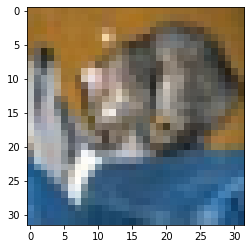

In [6]:
plt.imshow(testX[0,:,:,:])
plt.show

In [56]:
import matplotlib.pyplot as pyplot
summarize_diagnostics(history)

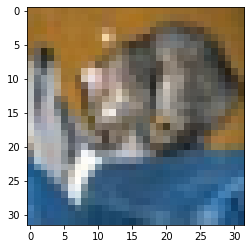

done taking gradients for train


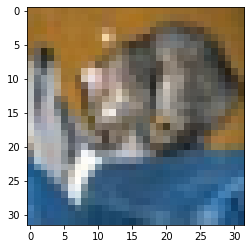

In [15]:
# load train and test dataset


# calculates channel-wise gradients of input images
# calculates 
def load_dataset():
	# load dataset
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # print(testX.shape)

    plt.imshow(testX[0,:,:,:])
    plt.show()

 
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    print("done taking gradients for train")
    return trainX, trainY, testX, testY


 

trainX, trainY, testX, testY = load_dataset()

plt.imshow(testX[0,:,:,:])
plt.show()


(10000, 32, 32, 3)


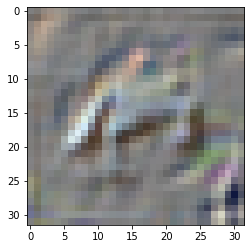

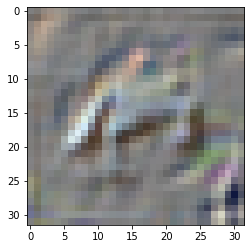

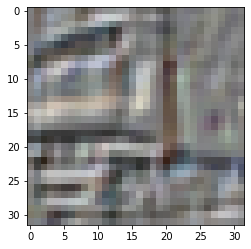

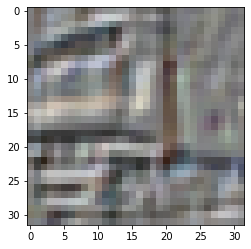

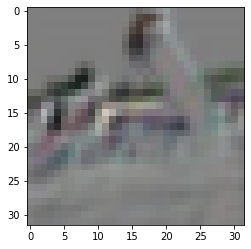

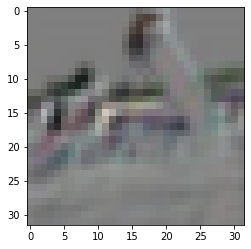

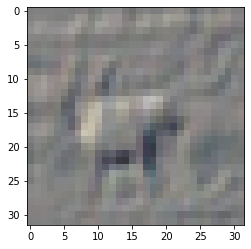

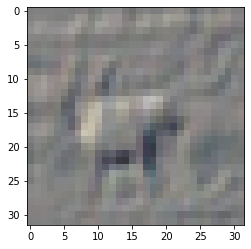

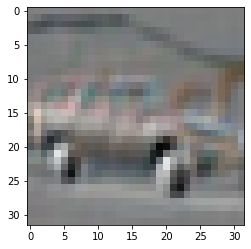

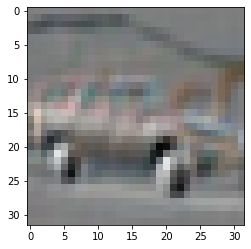

In [47]:
def sobel_filter_dataset(dataset):
    # convert to tensor and [0,1]
    dataset = tf.convert_to_tensor(np.array(dataset[:,:,:,:])/255)
    dataset = tf.image.sobel_edges(dataset)

    sobel_y = np.asarray(dataset[:, :, :, :, 0]) # sobel in y-direction
    sobel_y = np.clip(sobel_y / 4 + 0.5, 0, 1) # remap to [0,1]

    sobel_x = np.asarray(dataset[:, :, :, :, 1]) # sobel in x-direction
    sobel_x = np.clip(sobel_x / 4 + 0.5, 0, 1) # remap to [0,1]

    dataset = np.clip(0.5*sobel_x + 0.5*sobel_y, 0, 1)
    return dataset


(trainX, trainY), (testX, testY) = cifar10.load_data()
trainX = sobel_filter_dataset(trainX)
testX = sobel_filter_dataset(testX)
trainY = to_categorical(trainY)
testY = to_categorical(testY)
print(testX.shape)

for i in range(5):
    plt.imshow(trainX[i])
    plt.show()
    plt.imshow(dataset[i])
    plt.show()



In [ ]:
summarize_diagnostics(history)

In [5]:

# RUN VANILLA VGG 6
def prep_pixels(train, test):
	# convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    return train_norm, test_norm




# define cnn model
def define_model_VGG8():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.2))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
 

 
# CODE MODIFIED FROM tensorflow: Save and load models
def run_test_harness(trainX,testX,trainY,testY):

	from keras.callbacks import ModelCheckpoint, EarlyStopping
	checkpoint = ModelCheckpoint("/Users/andrewweng/developer/cnn-filter-metrics/vgg_6_vanilla2_checkpoints/vgg6_vanilla2.chkpt", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
	early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
	# load dataset
	# trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model_VGG8()
	# fit model
	history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), verbose=1, callbacks=[checkpoint,early])
	# evaluate model
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	return history
 
# entry point, run the test harness
history = run_test_harness(trainX,testX,trainY,testY)
summarize_diagnostics(history,'vgg6_vanilla2')

Epoch 1/100
782/782 [==============================] - 112s 143ms/step - loss: 2.1343 - accuracy: 0.2184 - val_loss: 1.6845 - val_accuracy: 0.3887

Epoch 00001: val_accuracy improved from -inf to 0.38870, saving model to /Users/andrewweng/developer/cnn-filter-metrics/vgg_6_vanilla2_checkpoints/vgg6_vanilla2.chkpt
Epoch 2/100
782/782 [==============================] - 123s 157ms/step - loss: 1.6757 - accuracy: 0.3895 - val_loss: 1.4441 - val_accuracy: 0.4758

Epoch 00002: val_accuracy improved from 0.38870 to 0.47580, saving model to /Users/andrewweng/developer/cnn-filter-metrics/vgg_6_vanilla2_checkpoints/vgg6_vanilla2.chkpt
Epoch 3/100
782/782 [==============================] - 123s 158ms/step - loss: 1.5080 - accuracy: 0.4518 - val_loss: 1.3586 - val_accuracy: 0.5055

Epoch 00003: val_accuracy improved from 0.47580 to 0.50550, saving model to /Users/andrewweng/developer/cnn-filter-metrics/vgg_6_vanilla2_checkpoints/vgg6_vanilla2.chkpt
Epoch 4/100
782/782 [============================

KeyboardInterrupt: 

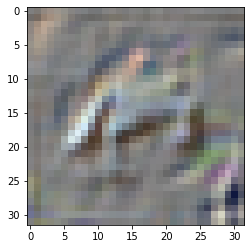

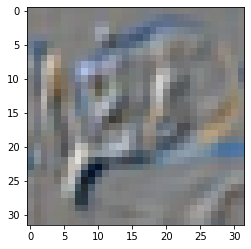

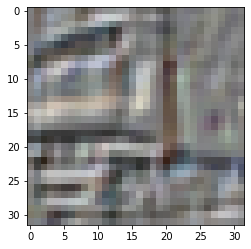

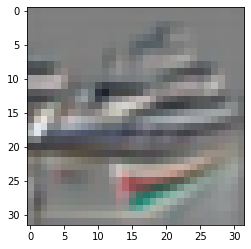

In [11]:
# RUN SOBEL ON VGG 5
# plot diagnostic learning curves
def summarize_diagnostics(history,name):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + name + 'vgg3_vanilla_plot.png')

	pyplot.close()



def sobel_filter_dataset(dataset):
    # convert to tensor and [0,1]
    dataset = tf.convert_to_tensor(np.array(dataset[:,:,:,:])/255)
    dataset = tf.image.sobel_edges(dataset)

    sobel_y = np.asarray(dataset[:, :, :, :, 0]) # sobel in y-direction
    sobel_y = np.clip(sobel_y / 4 + 0.5, 0, 1) # remap to [0,1]

    sobel_x = np.asarray(dataset[:, :, :, :, 1]) # sobel in x-direction
    sobel_x = np.clip(sobel_x / 4 + 0.5, 0, 1) # remap to [0,1]

    dataset = np.clip(0.5*sobel_x + 0.5*sobel_y, 0, 1)
    return dataset


(trainX, trainY), (testX, testY) = cifar10.load_data()
trainX = sobel_filter_dataset(trainX)
testX = sobel_filter_dataset(testX)
trainY = to_categorical(trainY)
testY = to_categorical(testY)

for i in range(2):
    plt.imshow(trainX[i])
    plt.show()
    plt.imshow(testX[i])
    plt.show()



[[0.5        0.49313725 0.5745098  0.61568627 0.61764706 0.57941176
  0.53235294 0.50784314 0.49313725 0.4627451 ]
 [0.44019608 0.46568627 0.58823529 0.64215686 0.63921569 0.58039216
  0.5        0.44901961 0.42156863 0.40784314]
 [0.55392157 0.63039216 0.7372549  0.70882353 0.63627451 0.54215686
  0.46372549 0.44117647 0.46666667 0.50294118]
 [0.56666667 0.67058824 0.72745098 0.64411765 0.56176471 0.50098039
  0.46372549 0.46372549 0.51372549 0.54607843]
 [0.58235294 0.67156863 0.67843137 0.59215686 0.53921569 0.52352941
  0.50980392 0.49509804 0.52843137 0.53823529]
 [0.59705882 0.66078431 0.63431373 0.56176471 0.51862745 0.50196078
  0.49019608 0.49313725 0.54607843 0.54411765]
 [0.57745098 0.61764706 0.59313725 0.54607843 0.49705882 0.48431373
  0.50392157 0.5245098  0.55294118 0.53333333]
 [0.55588235 0.56568627 0.54607843 0.49705882 0.46372549 0.48823529
  0.51372549 0.50098039 0.50588235 0.50588235]
 [0.57254902 0.56960784 0.54607843 0.48039216 0.47058824 0.5
  0.49509804 0.4784

In [26]:
# def prep_pixels(train, test):
# 	# convert from integers to floats
#     train_norm = train.astype('float32')
#     test_norm = test.astype('float32')
#     train_norm = train_norm / 255.0
#     test_norm = test_norm / 255.0
#     return train_norm, test_norm




# define cnn model
def define_model_VGG8():
	model = Sequential()
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',input_shape=(32,32,3)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.2))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
 
# plot diagnostic learning curves
def summarize_diagnostics(history,name):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + name + 'vgg3_vanilla_plot.png')

	pyplot.close()
 
# CODE MODIFIED FROM tensorflow: Save and load models
def run_test_harness(trainX,testX,trainY,testY):

    from keras.callbacks import ModelCheckpoint, EarlyStopping
    checkpoint = ModelCheckpoint("/Users/andrewweng/developer/cnn-filter-metrics/vgg_5_alone_checkpoints/vgg5_alone.chkpt", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
    early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
    trainX, testX = prep_pixels(trainX, testX)
    model = define_model_VGG8()
    # fit model
    history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), verbose=1, callbacks=[checkpoint,early])
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    return history
 
# entry point, run the test harness
history = run_test_harness(trainX,testX,trainY,testY)
summarize_diagnostics(history,'vgg5_sobel2')

Epoch 1/100
782/782 [==============================] - 180s 229ms/step - loss: 1.9601 - accuracy: 0.2845 - val_loss: 1.4813 - val_accuracy: 0.4717

Epoch 00001: val_accuracy improved from -inf to 0.47170, saving model to /Users/andrewweng/developer/cnn-filter-metrics/vgg_5_alone_checkpoints/vgg5_alone.chkpt
Epoch 2/100
626/782 [=======================>......] - ETA: 34s - loss: 1.4997 - accuracy: 0.4602

KeyboardInterrupt: 